In [4]:
!git clone https://github.com/HaiNLH/CrossCBR_exp.git

Cloning into 'CrossCBR_exp'...
remote: Enumerating objects: 537, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 537 (delta 15), reused 67 (delta 13), pack-reused 461
Receiving objects: 100% (537/537), 79.98 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Updating files: 100% (99/99), done.


In [6]:
%cd CrossCBR_exp

[Errno 2] No such file or directory: 'CrossCBR_exp'
/kaggle/working/CrossCBR_exp


In [47]:
import argparse
import numpy as np
import pandas as pd
import os
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
def get_graph(path, x, y):
    with open(os.path.join(path), 'r') as f:
        b_i_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))

    indice = np.array(b_i_pairs, dtype=np.int32)
    values = np.ones(len(b_i_pairs), dtype=np.float32)
    b_i_graph = sp.coo_matrix(
        (values, (indice[:, 0], indice[:, 1])), shape=(x, y)).tocsr()
    return b_i_graph


def save_sp_mat(csr_mat, name):
    sp.save_npz(name, csr_mat)


def load_sp_mat(name):
    return sp.load_npz(name)

def filter(threshold, mat):
    mask = mat >= threshold
    mat = mat * mask
    return mat

def gen_ii_asym(ix_mat, threshold=0):
    '''
    mat: ui or bi
    '''
    ii_co = ix_mat @ ix_mat.T
    i_count = ix_mat.sum(axis=1)
    i_count += (i_count == 0) # mask all zero with 1
    # norm_ii = normalize(ii_asym, norm='l1', axis=1)
    # return norm_ii
    # return ii_asym
    mask = ii_co > threshold
    ii_co = ii_co.multiply(mask)
    ii_asym = ii_co / i_count
    # normalize by row -> asym matrix
    return ii_co

def get_cmd():
    parser = argparse.ArgumentParser()
    # experimental settings
    parser.add_argument("-d", "--dataset", default="NetEase", type=str, help="dataset to train")
    args = parser.parse_args()
    return args

def get_stat(path):
    with open(path, 'r') as f:
        a, b, c = f.readline().split('\t')
    return int(a), int(b), int(c)


if __name__ == '__main__':
    
#     paras = get_cmd().__dict__
    dataset_name = 'electronic'

    users, bundles, items = get_stat(f'datasets/{dataset_name}/{dataset_name}_data_size.txt')
    dir = f'datasets/{dataset_name}'
    path = [dir + '/user_bundle_train.txt',
            dir + '/user_item.txt',
            dir + '/bundle_item.txt']
    
    raw_graph = [get_graph(path[0], users, bundles),
                 get_graph(path[1], users, items),
                 get_graph(path[2], bundles, items)]

    ub, ui, bi = raw_graph

    pbar = tqdm(enumerate([ui.T, bi.T]), total = 2, desc="gene", ncols=100)
    asym_mat = []
    for i, mat in pbar:
        asym_mat.append(gen_ii_asym(mat))

    pbar = tqdm(enumerate(["/iui_asym.npz", "/ibi_asym.npz"]), total = 2, desc="save", ncols=100)
    for i, data in pbar:
        save_sp_mat(asym_mat[i], dir + data)

save: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 61.32it/s]


In [87]:
# from gene_ii_asym import load_sp_mat

iui = load_sp_mat('datasets/electronic/iui_asym.npz')
print(iui.getnnz())
ibi = load_sp_mat('datasets/electronic/ibi_asym.npz')
print(ibi.getnnz())


ii_b_max = int(ibi.max())
print(ii_b_max)
ii_u_max = int(iui.max())
print(ii_u_max)


# bundle
print("statistic")
print("ii bundle")
lb1 = []
val1 = []
for i in range(1, 10):
    lb1.append(f'{i}')
    count = ibi.multiply(ibi == i).getnnz()
    val1.append(count)
    p = count / ibi.getnnz() * 100
    print("==", i, ":", p, "%")

count = ibi.multiply(ibi >= 10).getnnz()
val1.append(count)
lb1.append(f">={10}")
p = count / ibi.getnnz() * 100
print(">=", 10, ":", p, "%")


# user
print("ii user")
lb2 = []
val2 = []
for i in range(1, 10):
    lb2.append(f'{i}')
    count = iui.multiply(iui == i).getnnz()
    val2.append(count)
    p = count / iui.getnnz() * 100
    print("==", i, ":", p, "%")

count = iui.multiply(ibi >= 10).getnnz()
val2.append(count)
lb2.append(f">={10}")
p = count / ibi.getnnz() * 100
print(">=", 10, ":", p, "%")

26459
22273
31
53
statistic
ii bundle
== 1 : 76.28518834463252 %
== 2 : 21.05239527679253 %
== 3 : 1.7375297445337403 %
== 4 : 0.38611772100749786 %
== 5 : 0.179589637677906 %
== 6 : 0.09428455978090064 %
== 7 : 0.10326404166479594 %
== 8 : 0.013469222825842949 %
== 9 : 0.02244870470973825 %
>= 10 : 0.1257127463745342 %
ii user
== 1 : 46.05994179674213 %
== 2 : 25.768169620922937 %
== 3 : 1.3794928001814126 %
== 4 : 21.648588382025018 %
== 5 : 0.5933708756944707 %
== 6 : 2.5473373899240337 %
== 7 : 0.04535318795116973 %
== 8 : 0.24566310140216938 %
== 9 : 1.1073736724743943 %
>= 10 : 0.1257127463745342 %


In [88]:
val1, val2

([16991, 4689, 387, 86, 40, 21, 23, 3, 5, 28],
 [12187, 6818, 365, 5728, 157, 674, 12, 65, 293, 28])

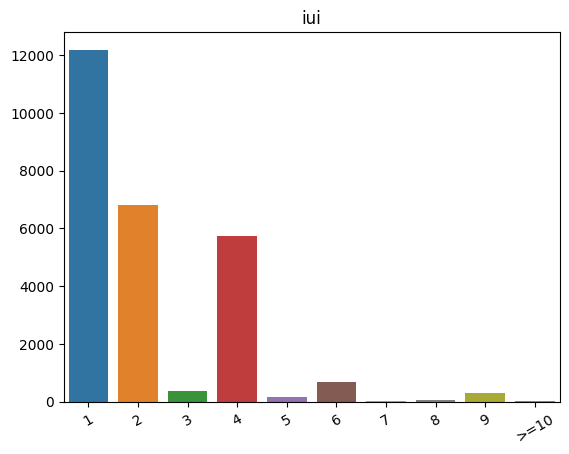

In [89]:
plt.title('iui')
temp1 = sns.barplot(x=lb2, y=val2)
temp1.set_xticklabels(temp1.get_xticklabels(), rotation=30)
plt.show()

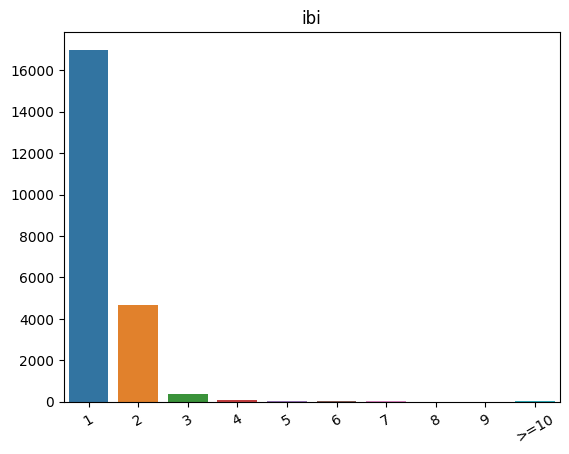

In [90]:
plt.title('ibi')
temp2 = sns.barplot(x=lb1, y=val1)
temp2.set_xticklabels(temp2.get_xticklabels(), rotation=30)
plt.show()

In [91]:
ub, ui, bi

(<888x1750 sparse matrix of type '<class 'numpy.float32'>'
 	with 1400 stored elements in Compressed Sparse Row format>,
 <888x3499 sparse matrix of type '<class 'numpy.float32'>'
 	with 4461 stored elements in Compressed Sparse Row format>,
 <1750x3499 sparse matrix of type '<class 'numpy.float32'>'
 	with 6165 stored elements in Compressed Sparse Row format>)

In [92]:
iu = ui.T
ib = bi.T
iu_count = iu.sum(axis=1)
ib_count = ib.sum(axis=1)

In [93]:
ib_count.max(), iu_count.max()

(31.0, 31.0)

In [94]:
ib_count, iu_count

(matrix([[1.],
         [3.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]], dtype=float32),
 matrix([[1.],
         [3.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]], dtype=float32))

In [95]:
temp1 = []
labels = []
g = 0
th = 30
for i in range(0, th):
    v = (ib_count == i).sum()
    temp1.append(v)
    labels.append(f'{i}')
    print(v)
    g+=v
    
v = (ib_count >= th).sum()
temp1.append(v)
labels.append(f'>{th-1}')
print(v)
g+=v

0
1927
1143
237
80
32
21
23
3
5
3
4
4
4
3
1
2
4
1
0
0
0
0
0
0
1
0
0
0
0
1


In [96]:
temp2 = []
labels2 = []
g2 = 0
th2 = 30
for i in range(0, th2):
    v2 = (iu_count == i).sum()
    temp2.append(v2)
    labels2.append(f'{i}')
    print(v2)
    g+=v2
    
v2 = (iu_count >= th).sum()
temp2.append(v)
labels2.append(f'>{th-1}')
print(v)
g2+=v

0
1927
1143
237
80
32
21
23
3
5
3
4
4
4
3
1
2
4
1
0
0
0
0
0
0
1
0
0
0
0
1


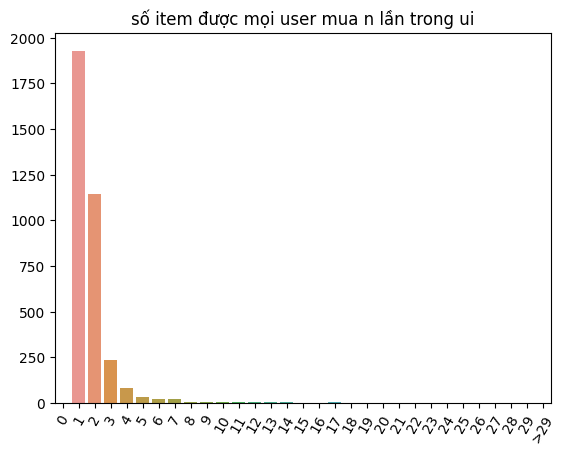

In [97]:
#  VD item 1 được mọi người mua 6 lần (mỗi người max 1 lần do cấu tạo dataset) -> cột 6: +1 
plt.title('số item được mọi user mua n lần trong ui')
iuc = sns.barplot(x=labels2, y=temp2)
iuc.set_xticklabels(iuc.get_xticklabels(), rotation=60)
plt.show()

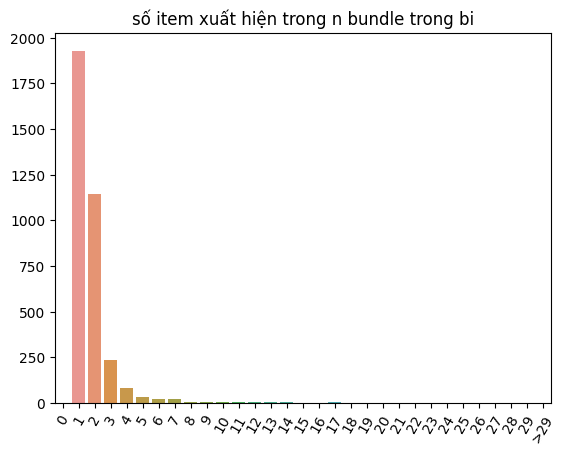

In [98]:
# VD item 4 xuất hiện trong bundle 2, 4, 6 -> cột 3: + 1
plt.title('số item xuất hiện trong n bundle trong bi')
ibc = sns.barplot(x=labels, y=temp1)
ibc.set_xticklabels(ibc.get_xticklabels(), rotation=60)
plt.show()

### New task 31/10


In [62]:
import pandas as pd
bi = pd.read_csv('/kaggle/working/CrossCBR_exp/datasets/electronic/bundle_item.txt', delimiter = "\t",header = None, names = ['bundle_id','item_id'])

In [63]:
bi

,bundle_id,item_id
0,0,2119
1,0,2521
2,0,998
3,1,995
4,1,2380
...,...,...
6160,1747,2343
6161,1748,729
6162,1748,2343
6163,1749,800


In [64]:
import itertools

# Assuming bundle_df is your DataFrame with columns "bundle_id" and "item_id"
# You can adapt this code to fit your specific DataFrame structure

unique_bundles = bi['bundle_id'].unique()
bundle_pairs = list(itertools.combinations(unique_bundles, 2))



# Now overlap_dict contains the overlaps for all possible bundle pairs

In [65]:
bi.describe

<bound method NDFrame.describe of       bundle_id  item_id
0             0     2119
1             0     2521
2             0      998
3             1      995
4             1     2380
...         ...      ...
6160       1747     2343
6161       1748      729
6162       1748     2343
6163       1749      800
6164       1749     3480

[6165 rows x 2 columns]>

In [66]:
from tqdm import tqdm
overlap_dict = {}
count = 0
data=[]
for bundle1, bundle2 in tqdm(bundle_pairs):
    items_in_bundle1 = set(bi[bi['bundle_id'] == bundle1]['item_id'])
#     print(f"Bundle_id:{bundle1} ")
#     print(f"{items_in_bundle1}\n")
    items_in_bundle2 = set(bi[bi['bundle_id'] == bundle2]['item_id'])
#     print(f"Bundle_id: {bundle2}" )
#     print(f"{items_in_bundle2}\n")
    overlap = items_in_bundle1.intersection(items_in_bundle2)
    num_items_bundle1 = len(items_in_bundle1)
    num_items_bundle2 = len(items_in_bundle2)
    num_overlap_items = len(overlap)
    if num_items_bundle1 == 0 or num_items_bundle2 == 0:
        jaccard_ratio = 0.0
    else:
        jaccard_ratio = num_overlap_items / (num_items_bundle1 + num_items_bundle2 - num_overlap_items)
    if overlap:
        # Store the overlap in a dictionary with a unique key for each pair
#         print(overlap)
        data.append({'bundle_id1': bundle1, 'bundle_id2': bundle2, 'num_bundles1': num_items_bundle1, 'num_bundles2': num_items_bundle2, 'overlap': num_overlap_items, 'jaccad': jaccard_ratio})
#         key = (bundle1, bundle2)
#         overlap_dict[key] = overlap
    count +=1
    # Store the overlap in a dictionary with a unique key for each pair
#     if count>1000:
#         break

100%|██████████| 1530375/1530375 [19:28<00:00, 1309.63it/s]


In [67]:
df = pd.DataFrame(data)

In [70]:
max(df.overlap)

9

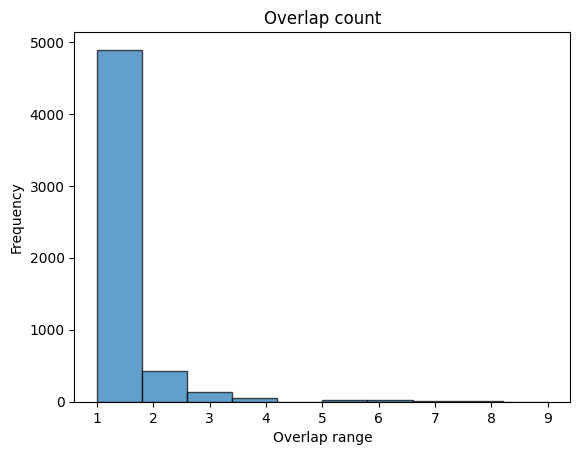

In [69]:
plt.hist(df['overlap'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Overlap range')
plt.ylabel('Frequency')
plt.title('Overlap count')
plt.show()

In [99]:
df.to_csv('elcetronic.csv', index=False)